In [1]:
%matplotlib inline 

import math
import numpy as np
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot
from xgboost.sklearn import XGBClassifier

from sklearn import preprocessing
from sklearn.preprocessing import Imputer

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation


In [2]:
dpath = "/home/steven/PIM"

In [3]:
data = pd.read_csv(dpath+'/resultsForMiningApril162016.csv')
data.shape

(234, 230)

In [4]:
data = data[np.isfinite(data['age'])]
vectors_frame = data.iloc[:,9:data.shape[1]]
labels_frame = data.iloc[:,0]

In [5]:
labels = labels_frame.as_matrix().astype(np.float32)
vectors = vectors_frame.as_matrix().astype(np.float32)

In [6]:
vectors.shape

(227, 221)

In [7]:
labels.shape

(227,)

In [8]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(vectors)
vectors = imp.transform(vectors)

In [9]:
#sel = VarianceThreshold()
#vectors = sel.fit_transform(vectors)
vectors = preprocessing.scale(vectors)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:184: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [10]:
selectK = SelectKBest(f_classif, k=60)
selectK.fit(vectors, labels)
vectors = selectK.transform(vectors)
vectors.shape

/usr/local/lib/python2.7/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 44  47  78  84  90 108 114 120 127 143 157 160] are constant.
  UserWarning)


(227, 30)

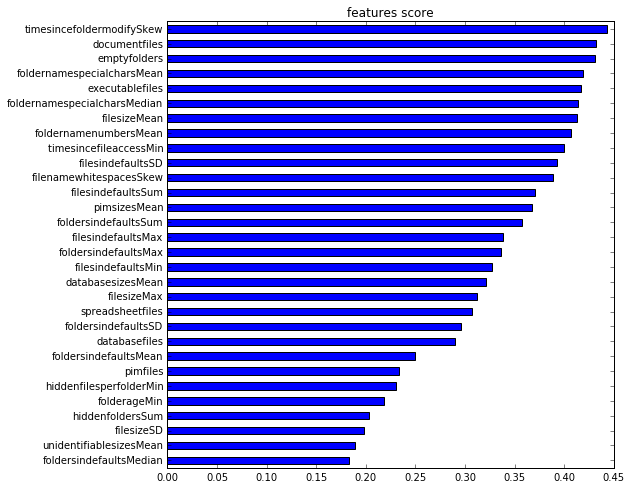

In [11]:
vectors_frame.columns[selectK.get_support()]
features = np.vstack((vectors_frame.columns, selectK.scores_))

mapFeat = dict(zip(["f"+str(i) for i in range(len(vectors_frame.columns))],vectors_frame.columns))
ts = pd.Series(selectK.scores_)
ts.index = vectors_frame.columns
ts.sort_values()[0:30].plot(kind="barh", title=("features score"), figsize=(8, 8))



In [12]:
param = {
 'n_estimators':[50,100,150,200],
 'max_depth':[2,3,4,5,6,7,8,9],
 'min_child_weight':[2,3,4,5],
 'colsample_bytree':[0.2,0.6,0.8],
 'colsample_bylevel':[0.2,0.6,0.8]
}


# https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

gsearch1 = GridSearchCV(estimator = XGBClassifier( 
        objective= 'reg:linear', 
        seed=1), 
    param_grid = param, 
    scoring='mean_absolute_error',
    cv=10,
    verbose = 1)

# http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# mean_squared_error


In [13]:
gsearch1.fit(vectors, labels)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    8.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   36.3s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:  4.1min
[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:  4.2min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 150, 200], 'colsample_bytree': [0.2], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9], 'min_child_weight': [2, 3, 4, 5], 'colsample_bylevel': [0.2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=1)

In [14]:
gsearch1.best_score_

-5.5154184927499239

In [15]:
gsearch1.best_params_
# gsearch1.grid_scores_

{'colsample_bylevel': 0.2,
 'colsample_bytree': 0.2,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 50}

In [16]:
param = gsearch1.best_params_
param['objective'] = 'reg:linear'
clf = XGBClassifier(**param)

In [21]:
scores = cross_validation.cross_val_score(clf, vectors, labels, cv=10,  scoring='mean_absolute_error')
print scores

[-11.5         -6.54285717  -3.59259248  -2.9130435   -3.52631569
  -3.2352941   -3.4666667   -3.42857146  -3.5         -2.46153855]


In [24]:
print("MAE: %0.2f (+/- %0.2f)" % (abs(scores.mean()), scores.std() * 2))

MAE: 4.42 (+/- 5.15)
